Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

<img src='https://drive.google.com/uc?export=view&id=1ZlF_cMtmWe5TWltnbWkoWGPm8amthmvW' width=500px>

Dans le cadre de ce projet, nous sommes un des ingénieurs IA au sein de l’équipe R&D de cette entreprise. Notre équipe est composée d’ingénieurs aux profils variés. Chacun des membres de l’équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur.

Nous allons dans un premier temps télécharger nos données.

# Import des données

Les images et masques sont contenus dans 2 dossiers :

- **leftlmg8bit**, qui contient les dossiers train, val et test des images d'origines.
- **gtFine**, qui contient les dossiers train, val et test des images labellisées avec 30 catégories.

Nous n'aurons besoin que de 8 catégories et non 30, nous verrons cela un peu plus tard dans le notebook.

Les 8 catégories sont les suivantes:
- void
- flat
- construction
- object
- nature
- sky
- human
- vehicle

Nous allons réorganiser nos données pour faciliter notre travail.

## Organisation du dataset

Les données de **Cityscape** étaient rangées de la manière suivante:
- **leftImg8bit**
    - test
        - berlin
        - bielefeld
        - bonn
        - ...
    - train
        - aachen
        - bochum
        - bremen
        - ...
    - val
        - frankfurt
        - lindau
        - munster
- **gtFine** 
    - test
        - berlin
        - bielefeld
        - bonn
    - train
        - aachen
        - bochum
        - bremen
        - ...
    - val
        - frankfurt
        - lindau
        - munster

Les images contenues dans les dossiers par zone du dossier gtFine sont sous trois formes:
- color
- instance
- label

Étant donné que les images sont classées aussi par lieu, nous allons toutes les réunir dans un même dossier.

Nous aurons donc:

- Un dossier **"train/images"** contenant toutes les images d'entrainement du dossier **"leftImg8bit/train"**.
- Un dossier **"train/masks30"** contenant tous les masks d'entrainement du dossier **"gtFine/val"** (celles-ci se terminent **"_labelIds.png"**).
- Un dossier **"test/images"** contenant toutes les images de validation du dossier **"leftImg8bit/val"**.
- Un dossier **"test/masks30"** contenant tous les masks de validation du dossier **"gtFine/val"** (celles-ci se terminent **"_labelIds.png"**).
- Un dossier **"val/images"** contenant une partie des images du dossier d'entrainement.
- Et dossier **"val/masks30"** contenant une partie des images du dossier d'entrainement. (celles-ci se terminent **"_labelIds.png"**)

In [1]:
# Import libraries
import numpy as np
import os
from glob import glob
import shutil
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple, Counter
from tqdm import tqdm
from imgaug import augmenters as iaa
from PIL import Image, ImageEnhance, ImageFilter

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

%matplotlib inline

2022-09-23 09:55:03.322993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-23 09:55:03.838631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/reda/anaconda3/envs/P8_3/lib/python3.10/site-packages/cv2/../../lib64:
2022-09-23 09:55:03.838655: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-23 09:55:03.900968: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

Les fichiers d'origines "test" ne sont pas utilisés au vu de leurs contenus (image noire pour tous les types d'images).

Nous utiliserons donc le contenu du dossier "val" pour les tests, et une partie du contenu des fichiers d'entrainements pour la validation.

In [1]:
# Fichiers d'origine
train_image_dir = 'data/leftImg8bit/train/*/*.png'
train_mask_dir = 'data/gtFine/train/*/*_labelIds.png'
val_image_dir = 'data/leftImg8bit/val/*/*.png'
val_mask_dir = 'data/gtFine/val/*/*_labelIds.png'

# Dossiers de destination
train_input_dir = 'data/train/images'
train_masks30_dir = 'data/train/masks30'
test_input_dir = 'data/test/images'
test_masks30_dir = 'data/test/masks30'
val_input_dir = 'data/val/images'
val_masks30_dir = 'data/val/masks30'

In [37]:
# Fonction permettant de copier-coller un fichier, du chemin d'origine au chemin de destination
def move_files(origin, destination):
    # Vérifie si l'origine est un répertoire ou une liste
    if isinstance(origin, list):
        origin_fname = origin
    else :
        origin_fname = glob(origin)
    
    for file in origin_fname:
        shutil.move(file, destination)

In [34]:
%%time
# 7 minutes d'execution
# move_files(train_image_dir, train_input_dir)
# move_files(train_mask_dir, train_masks30_dir)
# move_files(val_image_dir, test_input_dir)
# move_files(val_mask_dir, test_masks30_dir)

CPU times: user 5.65 s, sys: 1min 15s, total: 1min 21s
Wall time: 6min 44s


In [35]:
# Trie les images et les masks du dossier train
train_input_fname = sorted(
    [os.path.join(
        train_input_dir, fname) for fname in os.listdir(train_input_dir)])

train_target_fname = sorted(
    [os.path.join(
        train_masks30_dir, fname) for fname in os.listdir(train_masks30_dir)])

In [38]:
# Sépare les données d'entrainement et de validation  
val_input_path = train_input_fname[2380:]
val_target_path = train_target_fname[2380:]

In [39]:
%%time
# Déplace les fichiers du dossier train au dossier val
move_files(val_input_path, val_input_dir)
move_files(val_target_path, val_masks30_dir)

In [40]:
print("Nombre d'image d'entrainement: ", len(os.listdir(train_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(train_input_dir))[0])
print("Nombre de masks d'entrainement: ", len(os.listdir(train_masks30_dir)), '- nom du premier fichier: ', sorted(os.listdir(train_masks30_dir))[0])
print("Nombre des images de validation: ", len(os.listdir(val_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(val_input_dir))[0])
print("Nombre des masks de validation: ", len(os.listdir(val_masks30_dir)), '- nom du premier fichier: ', sorted(os.listdir(val_masks30_dir))[0])
print("Nombre d'image de test: ", len(os.listdir(test_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(test_input_dir))[0])
print("Nombre de masks de test: ", len(os.listdir(test_masks30_dir)), '- nom du premier fichier: ', sorted(os.listdir(test_masks30_dir))[0])

Nombre d'image d'entrainement:  2380 - nom du premier fichier:  aachen_000000_000019_leftImg8bit.png
Nombre de masks d'entrainement:  2380 - nom du premier fichier:  aachen_000000_000019_gtFine_labelIds.png
Nombre des images de validation:  595 - nom du premier fichier:  stuttgart_000104_000019_leftImg8bit.png
Nombre des masks de validation:  595 - nom du premier fichier:  stuttgart_000104_000019_gtFine_labelIds.png
Nombre d'image de test:  500 - nom du premier fichier:  frankfurt_000000_000294_leftImg8bit.png
Nombre de masks de test:  500 - nom du premier fichier:  frankfurt_000000_000294_gtFine_labelIds.png


Nous avons maintenant rangé nos images.

## Rename des masks

Nous allons renommer le nom de nos images pour qu'elles coïncident lors de nos essais.

In [41]:
# Fonction qui fournit le chemin du fichier à renommer
def rename_file(path, mask=False):
    # Liste des fichiers
    file_list = np.array(os.listdir(path))

    # Itère sur la liste de fichiers
    for filename in file_list:
        if mask == True:
            dest = filename.split('_gtFine_labelIds')[0]+'.png'
        else:
            dest = filename.split('_leftImg8bit')[0]+'.png'

        src = path + '/' + filename
        dest = path + '/' + dest
        os.rename(src, dest)

In [42]:
rename_file(train_input_dir, mask=False)
rename_file(train_masks30_dir, mask=True)
rename_file(test_input_dir, mask=False)
rename_file(test_masks30_dir, mask=True)
rename_file(val_input_dir, mask=False)
rename_file(val_masks30_dir, mask=True)

In [43]:
print("Nombre d'images d'entrainement:: ", len(os.listdir(train_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(train_input_dir))[0])
print("Nombre de masks d'entrainement: ", len(os.listdir(train_masks30_dir)), '- nom du premier fichier: ', sorted(os.listdir(train_masks30_dir))[0])
print("Nombre des images de validation: ", len(os.listdir(val_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(val_input_dir))[0])
print("Nombre des masks de validation: ", len(os.listdir(val_masks30_dir)), '- nom du premier fichier: ', sorted(os.listdir(val_masks30_dir))[0])
print("Nombre d'image de test: ", len(os.listdir(test_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(test_input_dir))[0])
print("Nombre de masks de test: ", len(os.listdir(test_masks30_dir)), '- nom du premier fichier: ', sorted(os.listdir(test_masks30_dir))[0])

Nombre d'image d'entrainement:  2380 - nom du premier fichier:  aachen_000000_000019.png
Nombre de masks d'entrainement:  2380 - nom du premier fichier:  aachen_000000_000019.png
Nombre des images de validation:  595 - nom du premier fichier:  stuttgart_000104_000019.png
Nombre des masks de validation:  595 - nom du premier fichier:  stuttgart_000104_000019.png
Nombre d'image de test:  500 - nom du premier fichier:  frankfurt_000000_000294.png
Nombre de masks de test:  500 - nom du premier fichier:  frankfurt_000000_000294.png


Nos données sont maintenant correctement rangées et correctement nommées, nous pouvons passer aux mapping, de sorte à n'avoir que 8 catégories.

# Mapping

Nous allons utiliser la méthodologie d'un des créateurs du jeu de données Marius Cordts. Nous allons reprendre les codes de son github à cette adresse : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

In [44]:
# Adaptation from the official Cityscapes scripts
# https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#--------------------------------------------------------------------------------
# Definitions : 
#--------------------------------------------------------------------------------
# Create tuple subclasses with named fields
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name the 30 classes

    'id'          , # An integer ID that is associated with this label.

    'categoryId'       , # IDs of labels which match to pixel values
                    # corresponding to the 8 main categories.

    'category'    , # The name of the category that this label belongs to
    ] )

#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

labels = [
    #name                             id    catId   category
    Label(  'unlabeled'            ,  0 ,      0 , 'void'),
    Label(  'ego vehicle'          ,  1 ,      0 , 'void'),
    Label(  'rectification border' ,  2 ,      0 , 'void'),
    Label(  'out of roi'           ,  3 ,      0 , 'void'),
    Label(  'static'               ,  4 ,      0 , 'void'),
    Label(  'dynamic'              ,  5 ,      0 , 'void'),
    Label(  'ground'               ,  6 ,      0 , 'void'),
    Label(  'road'                 ,  7 ,      1 , 'flat'),
    Label(  'sidewalk'             ,  8 ,      1 , 'flat'),
    Label(  'parking'              ,  9 ,      1 , 'flat'),
    Label(  'rail track'           , 10 ,      1 , 'flat'),
    Label(  'building'             , 11 ,      2 , 'construction'),
    Label(  'wall'                 , 12 ,      2 , 'construction'),
    Label(  'fence'                , 13 ,      2 , 'construction'),
    Label(  'guard rail'           , 14 ,      2 , 'construction'),
    Label(  'bridge'               , 15 ,      2 , 'construction'),
    Label(  'tunnel'               , 16 ,      2 , 'construction'),
    Label(  'pole'                 , 17 ,      3 , 'object'),
    Label(  'polegroup'            , 18 ,      3 , 'object'),
    Label(  'traffic light'        , 19 ,      3 , 'object'),
    Label(  'traffic sign'         , 20 ,      3 , 'object'),
    Label(  'vegetation'           , 21 ,      4 , 'nature'),
    Label(  'terrain'              , 22 ,      4 , 'nature'),
    Label(  'sky'                  , 23 ,      5 , 'sky'),
    Label(  'person'               , 24 ,      6 , 'human'),
    Label(  'rider'                , 25 ,      6 , 'human'),
    Label(  'car'                  , 26 ,      7 , 'vehicle'),
    Label(  'truck'                , 27 ,      7 , 'vehicle'),
    Label(  'bus'                  , 28 ,      7 , 'vehicle'),
    Label(  'caravan'              , 29 ,      7 , 'vehicle'),
    Label(  'trailer'              , 30 ,      7 , 'vehicle'),
    Label(  'train'                , 31 ,      7 , 'vehicle'),
    Label(  'motorcycle'           , 32 ,      7 , 'vehicle'),
    Label(  'bicycle'              , 33 ,      7 , 'vehicle'),
    Label(  'license plate'        , -1 ,      7 , 'vehicle')]

In [45]:
# Fonction de mise en correspondance des étiquettes et des catégories
def map_id2category(labels):
    """ This function maps the ~30 labels' IDs
        to the 8 main categories' IDs
    """
    cat_label = {label.id: label.categoryId for label in labels}

    map_category = np.vectorize(cat_label.get)
    return map_category

Les nouveaux masks (8 catégories) seront placés dans de nouveaux dossiers.

In [4]:
# Dossiers des masks avec 8 catégories
train_target_dir = 'data/train/masks8'
val_target_dir = 'data/val/masks8'
test_target_dir = 'data/test/masks8'

**imread()** décode l'image dans une matrice avec les canaux de couleur stockés dans l'ordre de Bleu, Vert, Rouge et A (Transparence) respectivement.

In [47]:
# Fonction pour la création des masks
def old_to_new_mask(img_path, msk30_path, msk8_path, labels):
    img_list = os.listdir(img_path)
    msk30_list = os.listdir(msk30_path)

    img_list.sort()
    msk30_list.sort()

    for i in range(0, len(img_list)):
        # Li les images et les masks
        img = cv2.imread(f'{img_path}/{img_list[i]}')
        msk30 = cv2.imread(f'{msk30_path}/{msk30_list[i]}', 
                           cv2.IMREAD_GRAYSCALE)
        
        # Convertis mask30 to mask8
        map_category = map_id2category(labels)
        msk8 = map_category(msk30)

        # Sauvegarde les nouveaux masks
        cv2.imwrite(f'{msk8_path}/{msk30_list[i]}', msk8)

In [48]:
%%time
# 50mn d'execution
# Sauvegarde les masks d'entrainement
old_to_new_mask(train_input_dir, train_masks30_dir, train_target_dir, labels)

# Sauvegarde les masks de validation
old_to_new_mask(val_input_dir, val_masks30_dir, val_target_dir, labels)

# Sauvegarde les masks de test
old_to_new_mask(test_input_dir, test_masks30_dir, test_target_dir, labels)

CPU times: user 12min 29s, sys: 0 ns, total: 12min 29s
Wall time: 17min 53s


In [49]:
print("Nombre d'images d'entrainement: ", len(os.listdir(train_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(train_input_dir))[0])
print("Nombre de masks d'entrainement: ", len(os.listdir(train_target_dir)), '- nom du premier fichier: ', sorted(os.listdir(train_target_dir))[0])
print("Nombre des images de validation: ", len(os.listdir(val_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(val_input_dir))[0])
print("Nombre des masks de validation: ", len(os.listdir(val_target_dir)), '- nom du premier fichier: ', sorted(os.listdir(val_target_dir))[0])
print("Nombre d'image de test: ", len(os.listdir(test_input_dir)), '- nom du premier fichier: ', sorted(os.listdir(test_input_dir))[0])
print("Nombre de masks de test: ", len(os.listdir(test_target_dir)), '- nom du premier fichier: ', sorted(os.listdir(test_target_dir))[0])

Nombre d'image d'entrainement:  2380 - nom du premier fichier:  aachen_000000_000019.png
Nombre de masks d'entrainement:  2380 - nom du premier fichier:  aachen_000000_000019.png
Nombre des images de validation:  595 - nom du premier fichier:  stuttgart_000104_000019.png
Nombre des masks de validation:  595 - nom du premier fichier:  stuttgart_000104_000019.png
Nombre d'image de test:  500 - nom du premier fichier:  frankfurt_000000_000294.png
Nombre de masks de test:  500 - nom du premier fichier:  frankfurt_000000_000294.png


Nous avons maintenant nos masks à 8 catégories rangés. Nous allons les visualiser.

# Visualisation

In [50]:
# Visualisation des images originales, des masks30 et des masks8
def visualize_img_msk30_msk8(img_path, msk30_path, msk8_path, n=0):
    img_list = os.listdir(img_path)
    msk30_list = os.listdir(msk30_path)
    msk8_list = os.listdir(msk8_path)

    img_list.sort()
    msk30_list.sort()
    msk8_list.sort()

    for i in range(n, n+5):
        img = cv2.imread(f'{img_path}/{img_list[i]}')
        msk30 = cv2.imread(f'{msk30_path}/{msk30_list[i]}', 
                           cv2.IMREAD_GRAYSCALE)
        msk8 = cv2.imread(f'{msk8_path}/{msk8_list[i]}',
                          cv2.IMREAD_GRAYSCALE)
        
        # Plot
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20, 20))
        ax1.imshow(img)
        ax1.set_title('Image origine')
        ax1.axis('off')
        ax2.imshow(msk30, cmap='nipy_spectral')
        ax2.set_title('30 catégorie')
        ax2.axis('off')
        ax3.imshow(msk8, cmap='nipy_spectral_r')
        ax3.set_title('8 catégories')
        ax3.axis('off')
        plt.show()

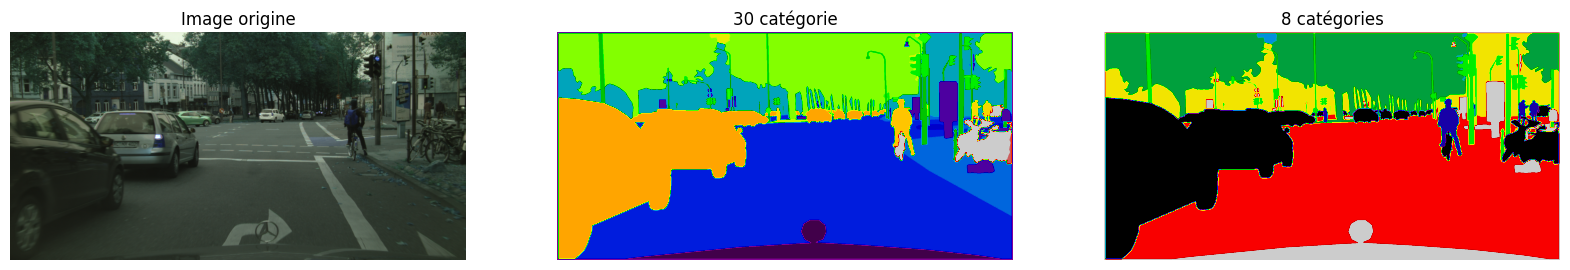

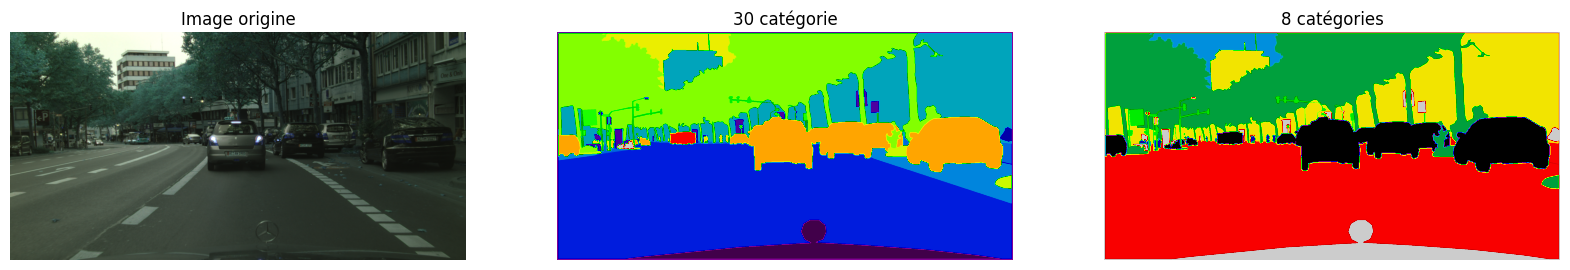

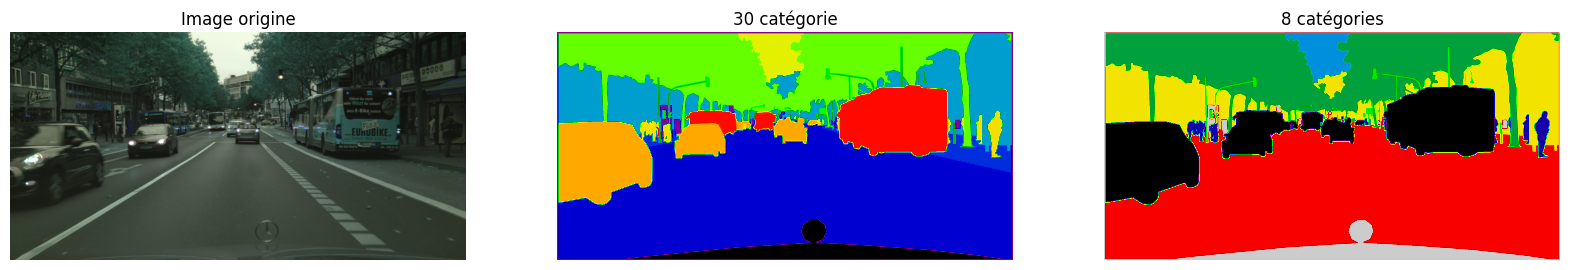

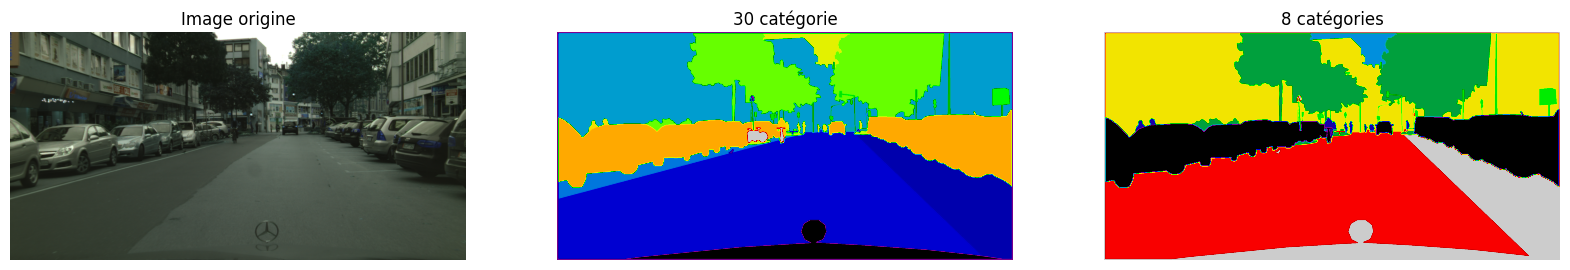

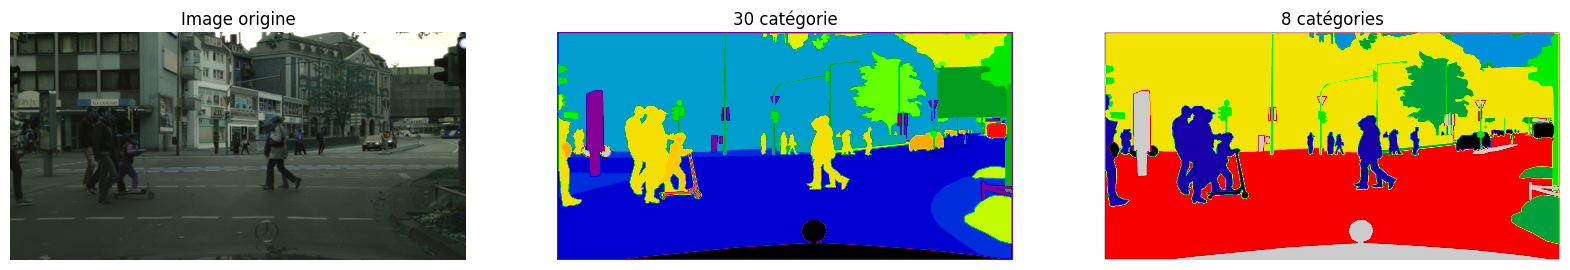

In [51]:
visualize_img_msk30_msk8(train_input_dir, train_masks30_dir,
                         train_target_dir, n=10)

On peut voir par exemple à la troisième ligne la différence entre le mask30 et le mask8, où dans le mask30 le bus est différencié des autres véhicules, contrairement au mask8 où tout véhicule fait partie d'une même catégorie.

## Distribution des classes

Nous allons maintenant voir d'à peu plus près comment chaque catégorie est distribuée sur l'ensemble des mask8.

In [52]:
# Fonction pour calculer et tracer la distribution des classes.
def class_distribution(msk_path, dataset='Train'):
    msk_list = os.listdir(msk_path)
    msk_list.sort()

    sums = []

    # Chargement des données de l'image
    for i in tqdm(range(0, len(msk_list))):
        mask = cv2.imread(f'{msk_path}/{msk_list[i]}',
                          cv2.IMREAD_GRAYSCALE)
        
        # Retourner une liste d'occurrences de chaque valeur d'étiquette unique
        (unique, counts) = np.unique(mask, return_counts=True)

        # Stocke le résultat dans une liste de dictionnaire
        sums.append(dict(zip(unique, counts)))

    result_counter = Counter()

    # Itère sur les éléments de la liste sums
    for elem in sums:
        for key, value in elem.items():
            result_counter[key] += value
    

    categ = {'void': 0, 'flat': 1, 'construction': 2, 
             'object': 3, 'nature': 4, 'sky': 5, 
             'human': 6, 'vehicle': 7}

    my_colors = ['black', 'red', 'yellow', 'greenyellow',
             'forestgreen', 'deepskyblue', 'royalblue', 'black']
    
    # Trace la distribution des classes
    plt.figure()
    plt.bar(x=categ.keys(), height=result_counter.values(),
            tick_label=list(categ.keys()), 
            color=my_colors)
    plt.xticks(rotation=45)
    plt.title(dataset +' Classes distribution')
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 2380/2380 [01:14<00:00, 32.03it/s]


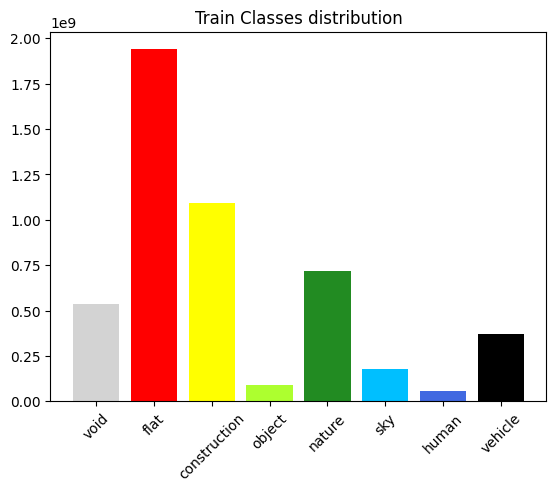

100%|█████████████████████████████████████████████████████████████████████████████████| 595/595 [00:18<00:00, 31.83it/s]


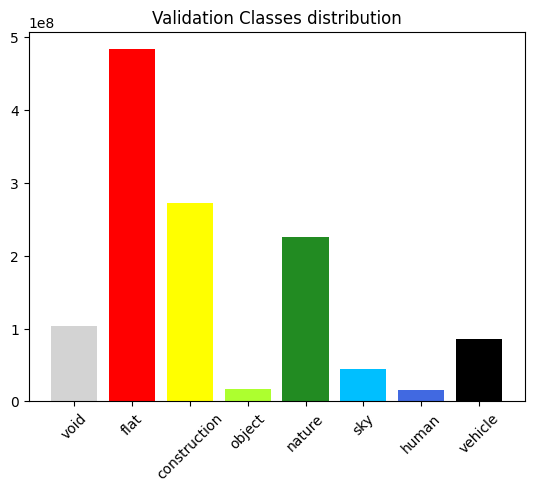

100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [00:15<00:00, 32.71it/s]


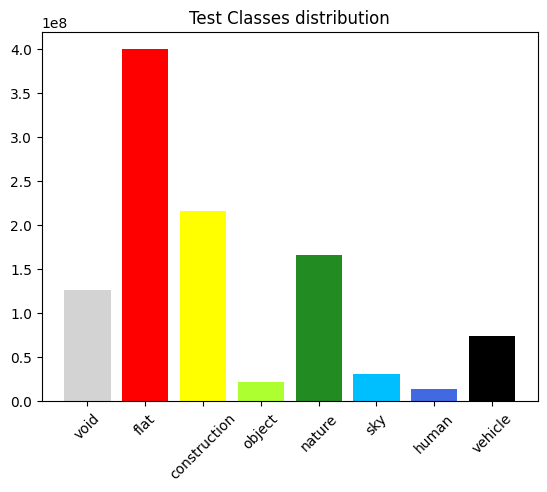

In [53]:
%%time
class_distribution(train_target_dir, dataset='Train')
class_distribution(val_target_dir, dataset='Validation')
class_distribution(test_target_dir, dataset='Test')

Nous sommes face à un dataset où les classes sont déséquilibrées, ce qui est une situation relativement fréquente sur les datasets de segmentation d'images.

Cette information est importante lorsqu'il s'agit de mesurer la performance de nos modèles. En effet, il faudra se méfier de l'exactitude (ou accuracy) car le modèle prédira probablement les classes surreprésentées avec beaucoup plus de robustesse que les classes sous-représentées.

Il faudra ainsi s'attacher à choisir une métrique adaptée.

# Resizing

Nous devons changer la taille de nos en images en 256x256 pour qu'elles puissent être utilisées par nos modèles. Cela va également permettre de réduire et libérer de l'espace pour la data augmentation.

In [54]:
# Chemin des trois dossiers 
train_image_dir_resize = 'data/train'
test_image_dir_resize = 'data/test'
val_image_dir_resize = 'data/val'

# Liste des chemins
list_dir = [train_image_dir_resize, test_image_dir_resize, val_image_dir_resize]

# Liste des sous-dossiers
list_sub_dir = ["images", "masks8", "masks30"]

In [55]:
%%time
# 10 minutes d'exécution
# Pour chaque dossier, nous itérons sur chaque sous-dossier, 
# pour ensuite resizer chaque image
for dir in list_dir:
    for sous_dossier in list_sub_dir:
        liste_image = os.listdir(dir + '/' + sous_dossier)
        print(dir)
        print(sous_dossier)
        for image_name in liste_image:
            image = Image.open(dir + '/' + sous_dossier + '/' + image_name)
            resized_image = image.resize((256, 256))
            resized_image.save(dir + '/' + sous_dossier + '/' + image_name)
            image = Image.open(dir + '/' + sous_dossier + '/' + image_name)
            print(image.size)

data/train
images
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(25

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

In [56]:
%%time
# Nous vérifions si les images sont à la bonne taille
for dir in list_dir:
    for sous_dossier in list_sub_dir:
        liste_image = os.listdir(dir + '/' + sous_dossier)
        for image_name in liste_image:
            image = Image.open(dir + '/' + sous_dossier + '/' + image_name)
            resultat = image.size == (256, 256)
            if resultat == False:
                print(dir)
                print(sous_dossier)
                print(image.size)

CPU times: user 3.65 s, sys: 0 ns, total: 3.65 s
Wall time: 13.8 s


# Data augmentation

Nous allons augmenter artificiellement notre dataset d'entrainement (uniquement).



(-0.5, 255.5, 255.5, -0.5)

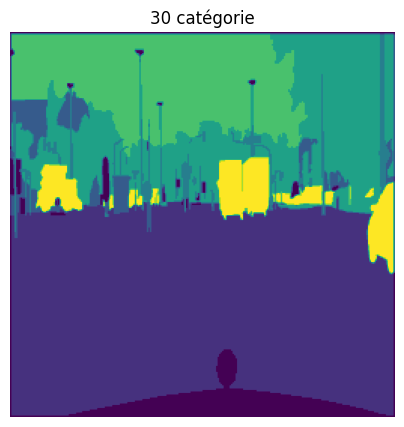

In [26]:
# train_input_path = sorted(glob(train_input_dir + '/*.png'))
train_target_path = sorted(glob(train_target_dir + '/*.png'))

# Charge l'image pour le test
msk8 = cv2.imread("data/train/masks8/darmstadt_000016_000019.png",
                  cv2.IMREAD_GRAYSCALE)

fig, (ax1) = plt.subplots(1, figsize=(5, 5))
ax1.imshow(msk8)
ax1.set_title('30 catégorie')
ax1.axis('off')

In [13]:
# Chemin des images d'entrainement
# dir_train_image = "data/train/images/"
dir_target_image = "data/train/masks8/"

# Liste des noms des images d'entrainement
# liste_name_img = sorted(os.listdir(dir_train_image))
liste_name_msk = sorted(os.listdir(dir_target_image))

In [15]:
%%time
# Récupère chaque image d'entrainement pour appliquer un effet
# de rotation, pour la sauvegarder ensuite dans le nouveau dossier "train_augmentation".
# Puis fais la même chose avec un effet de flou, etc.
for i in liste_name_msk:
#     img = load_img(dir_train_image + i)
#     img_rotate = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
#     img_blur = img.filter(ImageFilter.BLUR)
#     enhancer = ImageEnhance.Brightness(img)
#     img_brightness = enhancer.enhance(0.5)
#     img_brightness.save(r'data/train_augmentation/brightness_' + i)
#     img_rotate.save(r'data/train_augmentation/rotate_' + i)
#     img_blur.save(r'data/train_augmentation/blur_' + i)
    msk = load_img(dir_target_image + i)
    msk_rotate = msk.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
    msk_blur = msk.filter(ImageFilter.BLUR)
    enhancer = ImageEnhance.Brightness(msk)
    msk_brightness = enhancer.enhance(0.5)
    msk_brightness.save(r'data/train_augmentation/masks8/brightness_' + i)
    msk_rotate.save(r'data/train_augmentation/masks8/rotate_' + i)
    msk_blur.save(r'data/train_augmentation/masks8/blur_' + i)

CPU times: user 34.1 s, sys: 5.55 s, total: 39.7 s
Wall time: 1min 37s


In [66]:
# Liste des noms des images augmentées
liste_img_augmentation = sorted(os.listdir("data/train/images"))
liste_msk_augmentation = sorted(os.listdir("data/train/masks8"))

In [68]:
%%time
# for f_name in liste_img_augmentation:
#     if f_name.startswith('blur'):
#         shutil.move("data/train_augmentation/" + f_name, "data/train_augmentation/image_blur")
#     elif f_name.startswith('brightness'):
#         shutil.move("data/train_augmentation/" + f_name, "data/train_augmentation/image_brightness")
#     elif f_name.startswith('rotate'):
#         shutil.move("data/train_augmentation/" + f_name, "data/train_augmentation/image_rotate")

for f_name in liste_msk_augmentation:
    if f_name.startswith('blur'):
        shutil.move("data/train_augmentation/masks8/" + f_name, "data/train_augmentation/masks8/image_blur")
    elif f_name.startswith('brightness'):
        shutil.move("data/train_augmentation/masks8/" + f_name, "data/train_augmentation/masks8/image_brightness")
    elif f_name.startswith('rotate'):
        shutil.move("data/train_augmentation/masks8/" + f_name, "data/train_augmentation/masks8/image_rotate")

CPU times: user 5.73 s, sys: 10.2 s, total: 15.9 s
Wall time: 1min 32s


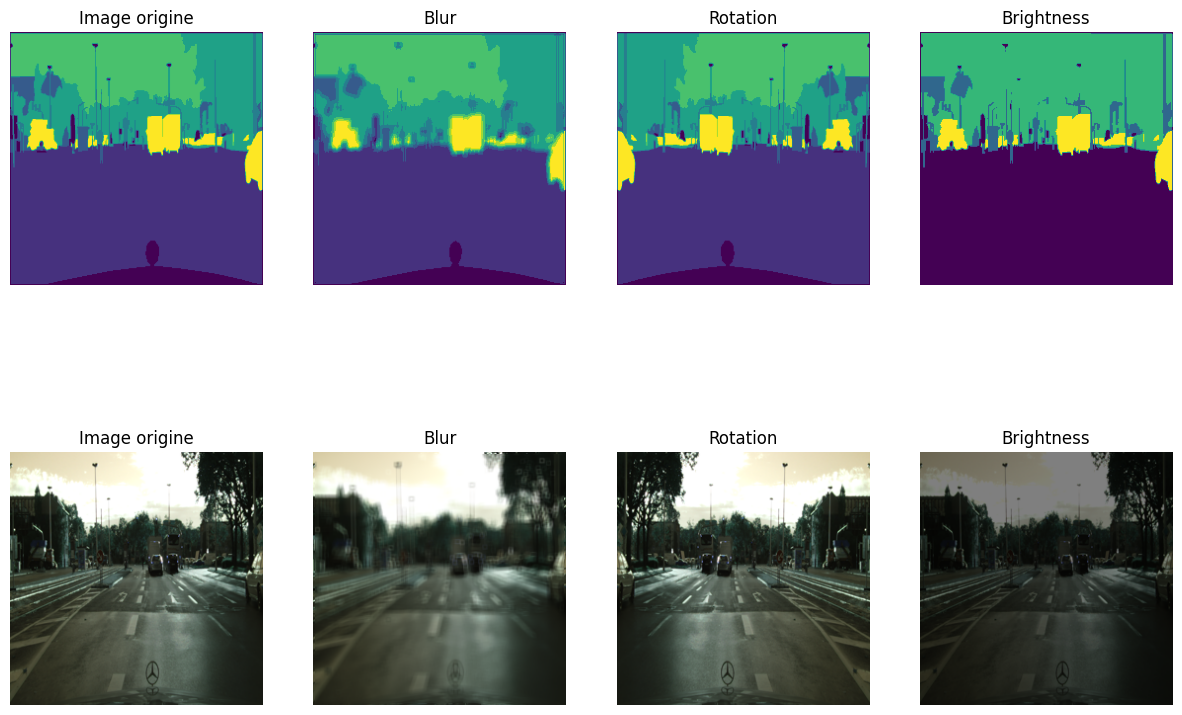

In [69]:
# Chargement des images pour test
msk8_blur = cv2.imread(
    "data/train_augmentation/masks8/image_blur/blur_darmstadt_000016_000019.png",
    cv2.IMREAD_GRAYSCALE)
msk8_rotate = cv2.imread(
    "data/train_augmentation/masks8/image_rotate/rotate_darmstadt_000016_000019.png",
    cv2.IMREAD_GRAYSCALE)
msk8_bright = cv2.imread(
    "data/train_augmentation/masks8/image_brightness/brightness_darmstadt_000016_000019.png",
    cv2.IMREAD_GRAYSCALE)
msk8_origin = cv2.imread("data/train/masks8/darmstadt_000016_000019.png",
                         cv2.IMREAD_GRAYSCALE)

# Chargement des images pour test
img_blur = cv2.imread(
    "data/train_augmentation/image_blur/blur_darmstadt_000016_000019.png")
img_rotate = cv2.imread(
    "data/train_augmentation/image_rotate/rotate_darmstadt_000016_000019.png")
img_bright = cv2.imread(
    "data/train_augmentation/image_brightness/brightness_darmstadt_000016_000019.png")
img_origin = cv2.imread("data/train/images/darmstadt_000016_000019.png")

fig, axs = plt.subplots(2, 4, figsize=(15, 10))
axs[0,0].imshow(msk8_origin)
axs[0,0].set_title('Image origine')
axs[0,0].axis('off')
axs[0,1].imshow(msk8)
axs[0,1].set_title('Blur')
axs[0,1].axis('off')
axs[0,2].imshow(msk8_rotate)
axs[0,2].set_title('Rotation')
axs[0,2].axis('off')
axs[0,3].imshow(msk8_bright)
axs[0,3].set_title('Brightness')
axs[0,3].axis('off')

axs[1,0].imshow(img_origin)
axs[1,0].set_title('Image origine')
axs[1,0].axis('off')
axs[1,1].imshow(img_blur)
axs[1,1].set_title('Blur')
axs[1,1].axis('off')
axs[1,2].imshow(img_rotate)
axs[1,2].set_title('Rotation')
axs[1,2].axis('off')
axs[1,3].imshow(img_bright)
axs[1,3].set_title('Brightness')
axs[1,3].axis('off')

plt.show()

Notre analyse exploratoire est maintenant terminée.

Nous avons également augmenté artificiellement notre dataset d'image en ajoutant du flou sur nos images d'entrainement. Nous pourrons alors comparer nos modèles par la suite.

Passons à la partie modeling avec le prochain notebook.